In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from xgboost import plot_importance
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute


# Loading data

In [72]:
df = pd.read_csv("C:\\Users\\kpetu\\OneDrive\\Pulpit\\jupyter\data\\car_selekcja.csv")
df.head(10)

,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,CO2_emissions,Transmission,Type,Doors_number
0,92000,PLN,Used,Abarth,124,2016,7200.0,170.0,1368.0,Gasoline,NaN,Manual,convertible,2.0
1,22950,PLN,Used,Aixam,Other,2018,4666.0,5.0,NaN,Electric,NaN,Automatic,small_cars,2.0
2,182900,PLN,New,Alfa Romeo,Giulia,2021,1.0,200.0,1995.0,Gasoline,142.0,Automatic,sedan,4.0
3,178000,PLN,Used,Alfa Romeo,Giulia,2017,23000.0,510.0,2891.0,Gasoline,212.0,Automatic,sedan,4.0
4,79900,PLN,Used,Alfa Romeo,Giulia,2020,5440.0,280.0,1995.0,Gasoline,152.0,Automatic,sedan,4.0
5,23000,PLN,Used,Alfa Romeo,159,2011,116000.0,120.0,1910.0,Diesel,NaN,Manual,station_wagon,4.0
6,73498,PLN,Used,Alfa Romeo,Giulia,2016,159900.0,180.0,2143.0,Diesel,109.0,Automatic,sedan,4.0
7,97700,PLN,Used,Alfa Romeo,Giulia,2016,57900.0,200.0,1995.0,Gasoline,138.0,Automatic,sedan,4.0
8,139799,PLN,Used,Alfa Romeo,Stelvio,2018,19892.0,201.0,1995.0,Gasoline,NaN,Automatic,SUV,5.0
9,203852,PLN,New,Alfa Romeo,Giulia,2020,1.0,190.0,2143.0,Diesel,126.0,Automatic,sedan,4.0


# EDA

In [73]:
#Changing values in Currency and Condition columns to 1/0
df['Currency'] = [1 if x == 'PLN' else 0 for x in df['Currency']]
df['Condition'] = [1 if x == 'New' else 0 for x in df['Condition']]

# Missing values

Handling NaNs


In [74]:
df.isna().sum()

Price                    0
Currency                 0
Condition                0
Vehicle_brand            0
Vehicle_model            0
Production_year          0
Mileage_km             983
Power_HP               643
Displacement_cm3      1966
Fuel_type                0
CO2_emissions       114257
Transmission           479
Type                     0
Doors_number          1487
dtype: int64

We will eliminate missing data from categorical variables by filling them with mode taken from the column. These colums are 'Doors_number' and 'Transmission'.
We can use mode because Manual and 5 doors are the most common values and second value is far behind.


In [75]:
print(df['Transmission'].value_counts())
print(df['Doors_number'].value_counts())

Manual       132889
Automatic     74936
Name: Transmission, dtype: int64
5.0     158814
4.0      27875
3.0      12845
2.0       7215
6.0         51
7.0          8
1.0          4
9.0          2
55.0         2
10.0         1
Name: Doors_number, dtype: int64


In [76]:
df['Doors_number'] = df['Doors_number'].fillna(float(df['Doors_number'].mode()))
df['Transmission'] = df['Transmission'].fillna( df['Transmission'].mode() )


'CO2_emissions' column has too many missing values. We won't contain this variable in our model

In [77]:
df.drop('CO2_emissions', inplace=True, axis=1)

We want to fill missing values in numerical variables with median. 'Power_HP' and 'Displacement_cm3' have little missing values.

In [78]:
for col in ['Mileage_km','Power_HP','Displacement_cm3']:
    median = float(df[col].median())
    df[col] = df[col].fillna(median)

## Changing type of the data

In [79]:
dict_type = {'Price': 'int64','Currency':'bool','Condition':'bool','Vehicle_brand':'object','Vehicle_model':'object','Production_year':'object','Mileage_km':'int64','Power_HP':'int64','Displacement_cm3':'int64',
'Fuel_type':'object','Transmission':'object','Type':'object','Doors_number':'object'}
df = df.astype(dict_type)

In [80]:
df.describe()

,Price,Mileage_km,Power_HP,Displacement_cm3
count,2.083040e+05,2.083040e+05,208304.000000,208304.000000
mean,6.305383e+04,1.502498e+05,151.787397,1881.768991
std,8.665967e+04,2.930508e+06,77.568529,726.204442
min,5.000000e+02,1.000000e+00,1.000000,400.000000
25%,1.780000e+04,5.358875e+04,105.000000,1490.000000
50%,3.570000e+04,1.445660e+05,136.000000,1798.000000
75%,7.599000e+04,2.056975e+05,170.000000,1997.000000
max,6.999000e+06,1.111111e+09,1398.000000,8400.000000


In [81]:
#There are big values in Price and Milleage columns.
#We'll change their unit to reduce values.
df['Price'] = df['Price']/1000
df['Mileage_km'] = df['Mileage_km']/10000
df = df.rename(columns={"Price": "Price_1000", "Mileage_km": "Mileage_10000km"})

In [82]:
#let's see unique values of the variables
for i in df.columns:
    print(i,len(df[i].unique()))

Price_1000 14142
Currency 2
Condition 2
Vehicle_brand 108
Vehicle_model 1203
Production_year 92
Mileage_10000km 52007
Power_HP 573
Displacement_cm3 1181
Fuel_type 8
Transmission 3
Type 9
Doors_number 10


In [83]:
counter = df['Vehicle_brand'].value_counts()
print(counter>500)

Volkswagen     True
BMW            True
Audi           True
Opel           True
Ford           True
              ...  
Santana       False
MAN           False
FAW           False
NSU           False
Talbot        False
Name: Vehicle_brand, Length: 108, dtype: bool


We want to have lists of brand and model, which contain brands and models that have more than 500 counts.
There are a lot of single model in our data. We want to join them and show on the plot

In [84]:
brand_list = []
for i in df['Vehicle_brand'].unique():
    if df['Vehicle_brand'].value_counts()[i]>500:
        brand_list.append(i)
print(brand_list)

model_list = []
for i in df['Vehicle_model'].unique():
    if df['Vehicle_model'].value_counts()[i]>500:
        model_list.append(i)
print(model_list)

['Alfa Romeo', 'Audi', 'BMW', 'Chevrolet', 'Chrysler', 'Citroën', 'Dacia', 'Dodge', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Jaguar', 'Jeep', 'Kia', 'Land Rover', 'Lexus', 'Mazda', 'Mercedes-Benz', 'MINI', 'Mitsubishi', 'Nissan', 'Opel', 'Toyota', 'Volvo', 'Volkswagen', 'Renault', 'Peugeot', 'Porsche', 'Seat', 'Škoda', 'Subaru', 'Suzuki']
['Other', 'A3', 'A4', 'A6', 'Seria 3', 'Seria 1', 'Seria 5', 'Seria 7', 'X1', 'X3', 'X5', 'C4 Picasso', 'C4', '308', 'Panda', '500', 'Focus', 'Kuga', 'Mondeo', 'S-Max', 'Civic', 'Jazz', 'Tucson', 'I30', 'Sportage', 'Ceed', '3', 'Klasa E', 'Klasa C', 'Klasa S', 'Klasa A', 'Klasa B', '407', 'Qashqai', 'Micra', 'Astra', 'Corsa', 'Insignia', 'Meriva', 'Zafira', '207', 'Captur', 'Clio', 'Scenic', 'Megane', 'Laguna', 'Ibiza', 'Octavia', 'Superb', 'Fabia', 'Swift', 'Avensis', 'Corolla', 'Yaris', 'Auris', 'Golf Plus', 'Golf', 'Passat', 'V60', 'A5', 'A8', 'Q5', 'Berlingo', 'C3', 'C4 Grand Picasso', 'C5', 'Leon', 'Duster', 'Tipo', 'C-MAX', 'Fiesta', 'Accord', 'CR-V

### Charts

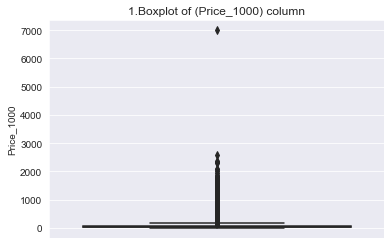

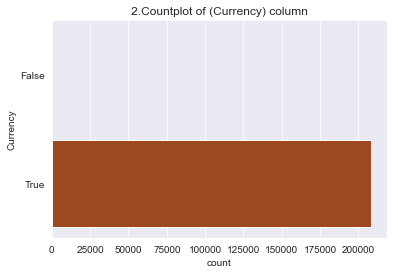

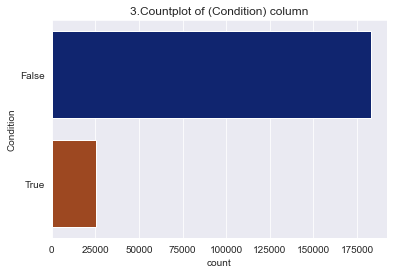

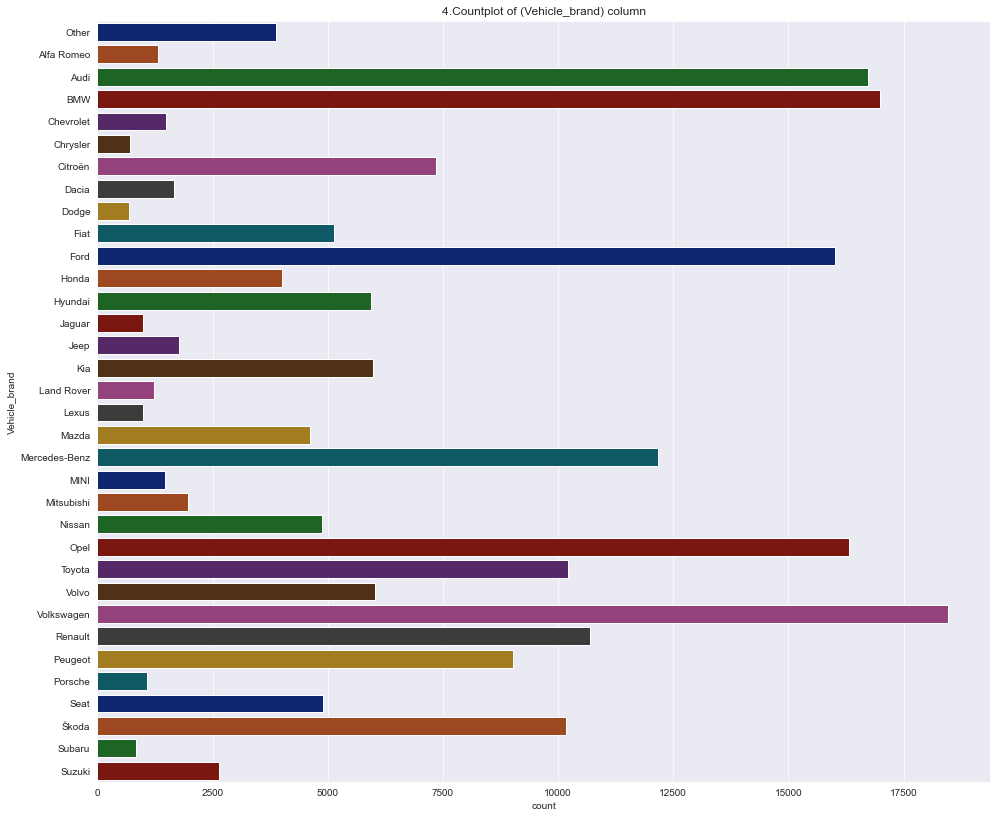

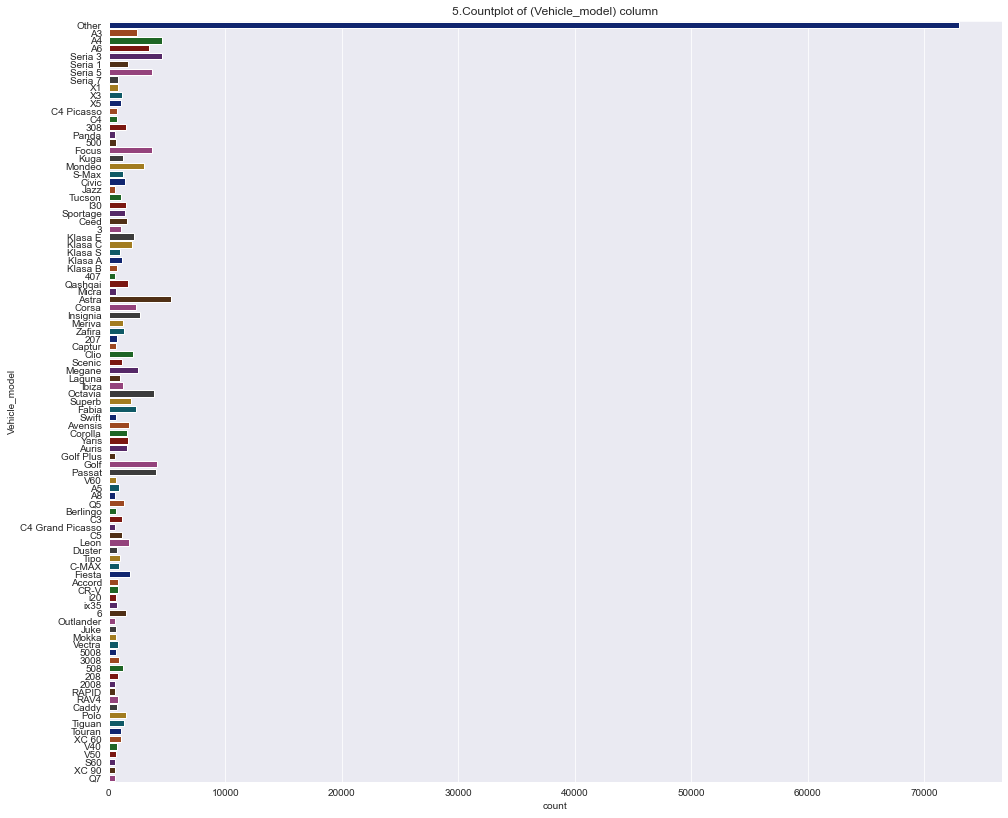

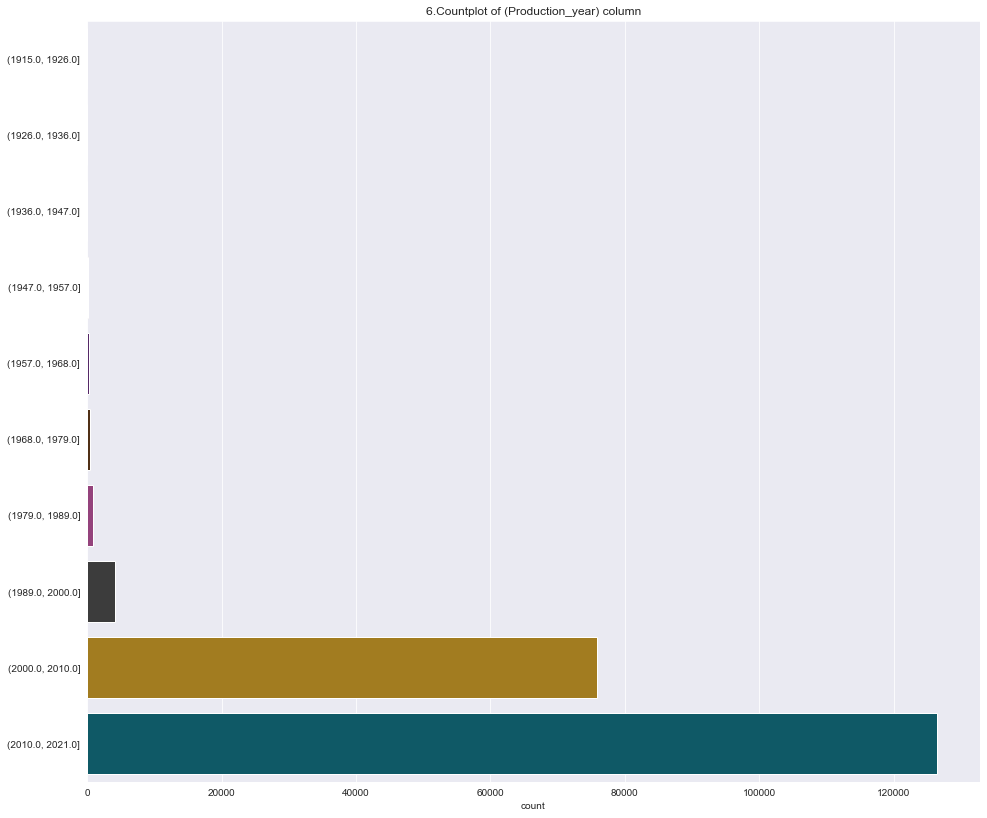

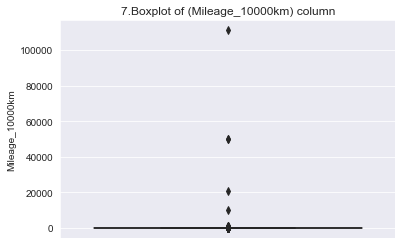

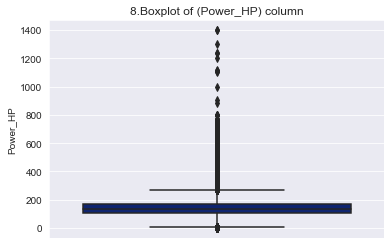

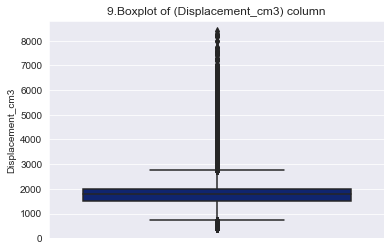

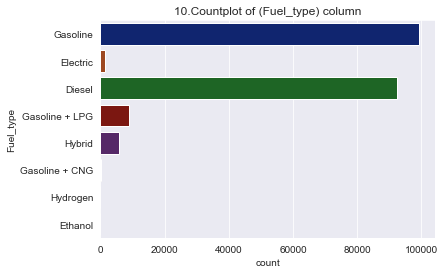

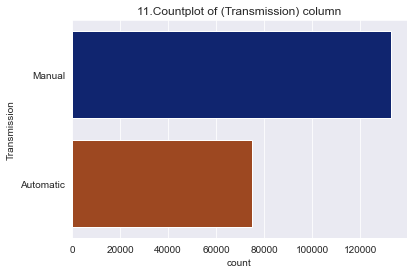

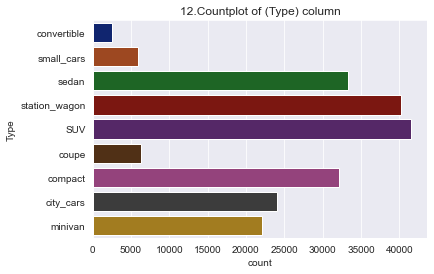

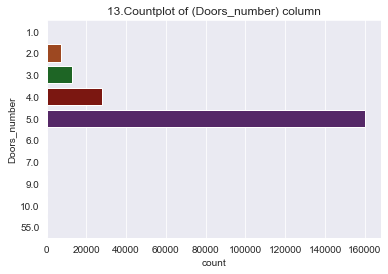

In [85]:
sns.set_style("darkgrid")
for num,col in enumerate(df.columns):
    if col == 'Production_year':
        plt.figure(figsize=(16,14))
        sns.countplot(data=df,y=pd.cut(np.array(df.Production_year), 10, precision=0), palette='dark').set(title='{}.Countplot of ({}) column'.format(num+1,col))
        plt.show()
    elif col == 'Vehicle_brand':
        plt.figure(figsize=(16,14))
        column = df[col]
        new_column=column.apply(lambda x: x if x in brand_list else 'Other')
        sns.countplot(y=new_column, palette='dark').set(title='{}.Countplot of ({}) column'.format(num+1,col))
        plt.show()
    elif col == 'Vehicle_model':
        plt.figure(figsize=(16,14))
        column = df[col]
        new_column=column.apply(lambda x: x if x in model_list else 'Other')
        sns.countplot(y=new_column, palette='dark').set(title='{}.Countplot of ({}) column'.format(num+1,col))
        plt.show()
    elif df[col].dtype in ['float64','int64']:
        sns.boxplot(data=df,y = col,palette='dark').set(title='{}.Boxplot of ({}) column'.format(num+1,col))
        plt.show()
    else:
        sns.countplot(data=df,y=col, palette='dark').set(title='{}.Countplot of ({}) column'.format(num+1,col))
        plt.show()

1. On Price chart we can see that the value has outliers. We want to get rid of these outliers. Our data should not have cars that cost over 7 milion PLN.

2. On Currency chart, we can see that there is very small amount of false value. The coulumn represents currency in which the annoucement was published. We can delete all the false values. Otherwise, we would have to connect EUR with PLN. Proportion between them is constantly changing, so it is simplier to just delete EUR values.

3. There are far more used cars in our database.

4. 5.On vehicle brand and model we can hardly see anything. That's because there are too many unique vales to fit the chart. We should delete the model column. There are to many unique values and we don't want to evaluate price based on model. Same with brand. There id a lot of single cars that have diffrent brand and model.

6. Production_year columns shows us that there are realy old cars in our dataset. Values starts growing around 1985. Older models are just simple cases. We should get rid of very old models, they could affect our model. Older cars are hard to price.

7. Mileage column also have outliers. Boxplot shows car with 1000000000km mileage. We have to get rid of outliers and false values.

8. Power_HP boxplot shows that there are outliers. Cars can have over 1000 Horse Power but it's not frequent.

9. There are many values in Displacement column which are higher that normal. We should also get rid of outliers.

10. Ethanol, Hydrogen and Gasoline + CNG does not have enough counts. We should delete those rows that have this type of fuel.

11. There are more Manual cars.

12. There is a lot of SUV but least convertible cars.

13. We should limit door number to 5 or less. Other values would be an input error.






In [86]:
df['Currency'].value_counts() 


True     208034
False       270
Name: Currency, dtype: int64

In [87]:
df['Fuel_type'].value_counts() 

Gasoline          99352
Diesel            92415
Gasoline + LPG     9027
Hybrid             5883
Electric           1553
Gasoline + CNG       70
Hydrogen              2
Ethanol               2
Name: Fuel_type, dtype: int64

In [88]:
df['Doors_number'].value_counts()

5.0     160301
4.0      27875
3.0      12845
2.0       7215
6.0         51
7.0          8
1.0          4
9.0          2
55.0         2
10.0         1
Name: Doors_number, dtype: int64

In [89]:
#Removing rows that have greater vales than 0.99 quantile of Price column
Q = df['Price_1000'].quantile(0.99)
df = df[df['Price_1000'] < Q]

#Removing rows that contain Price in EUR and then dropping Currency column
df = df[df['Currency'] == True]
df.drop('Currency', inplace=True, axis=1)

#Dropping Vehicle brand and model columns
df.drop('Vehicle_brand', inplace=True, axis=1)

df.drop('Vehicle_model', inplace=True, axis=1)

#Limiting age of cars
df = df[df['Production_year'] > 1985]

#Removing rows that have greater vales than 0.99 quantile of Milleage column
Q = df['Mileage_10000km'].quantile(0.995)
df = df[df['Mileage_10000km'] < Q]

#Removing rows that have greater vales than 0.99 quantile of Power column
Q = df['Power_HP'].quantile(0.99)
df = df[df['Power_HP'] < Q]

#Removing rows that have greater vales than 0.99 quantile of Displacement column
Q = df['Displacement_cm3'].quantile(0.99)
df = df[df['Displacement_cm3'] < Q]

#Removing rows that have Fuel type equal to Gasoline + CNG, Ethanol or Hydrogen
df = df[(df['Fuel_type'] == 'Electric')|(df['Fuel_type'] == 'Gasoline')|(df['Fuel_type'] == 'Diesel')|(df['Fuel_type'] == 'Gasoline + LPG')|(df['Fuel_type'] == 'Hybrid')]

#Removing rows that does not contain doors number between 2 and 5
df = df[(df['Doors_number'] < 6)&(df['Doors_number'] > 1)]




Lets see plots after changes

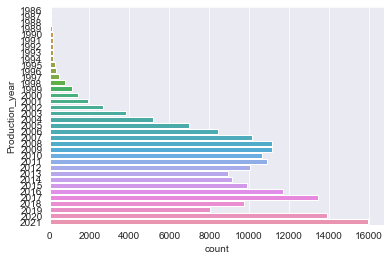

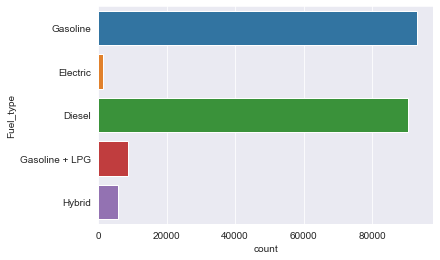

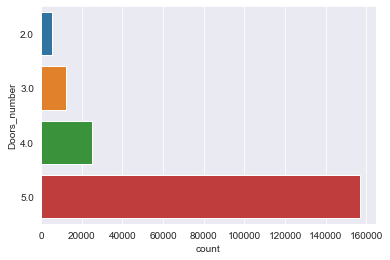

In [90]:
#Categorical variables
sns.countplot(data=df, y='Production_year')
plt.show()
sns.countplot(data=df, y='Fuel_type')
plt.show()
sns.countplot(data=df, y='Doors_number')
plt.show()

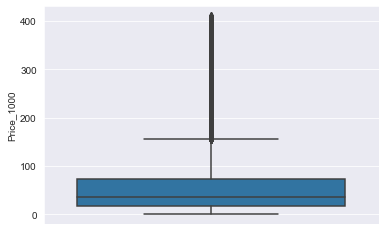

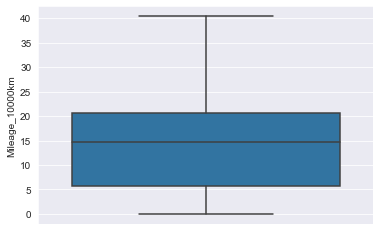

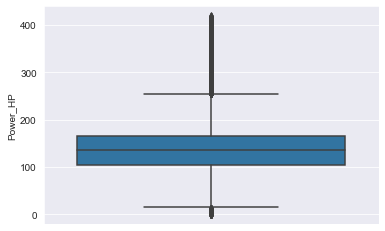

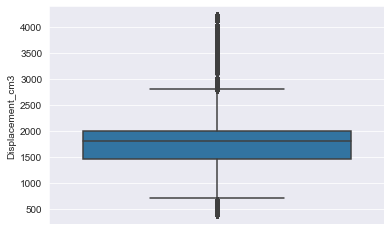

In [91]:
#Numerical variables
sns.boxplot(data=df, y='Price_1000')
plt.show()
sns.boxplot(data=df, y='Mileage_10000km')
plt.show()
sns.boxplot(data=df, y='Power_HP')
plt.show()
sns.boxplot(data=df, y='Displacement_cm3')
plt.show()

# Prepare data for modeling

Changing categorical variables to dummy variables

In [92]:
X = pd.get_dummies(df)

c:\Users\kpetu\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [93]:
# splitting columns to y - explained variable (Price) and X - explanatory variables
y = X['Price_1000']
X.drop('Price_1000', inplace=True, axis=1)

In [94]:
#Splitting dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Linear regression

In [95]:
X = sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float)).fit()

Parameters of linear model

In [96]:
model.params

const                 9.207033
Condition             0.270035
Mileage_10000km      -1.097977
Power_HP              0.523006
Displacement_cm3     -0.011919
                        ...   
Type_station_wagon   -3.663979
Doors_number_2.0     -0.798583
Doors_number_3.0      5.177449
Doors_number_4.0      4.858647
Doors_number_5.0     -0.030480
Length: 61, dtype: float64

In [97]:
model.tvalues

const                  10.374198
Condition               0.616661
Mileage_10000km       -84.752620
Power_HP              231.008194
Displacement_cm3      -48.553969
                         ...    
Type_station_wagon    -16.301782
Doors_number_2.0       -1.672336
Doors_number_3.0       15.882283
Doors_number_4.0       15.032844
Doors_number_5.0       -0.110082
Length: 61, dtype: float64

# Xgboost

In [98]:
#training our model
model = XGBRegressor()

### Cross validation

In [99]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 9.085 (0.117)


In this case, we can see that the model achieved a MAE of about 2.1 and std of 117.

This is a good score.

### Fitting model

In [100]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
error = y_pred - y_test

Gradient boost tree

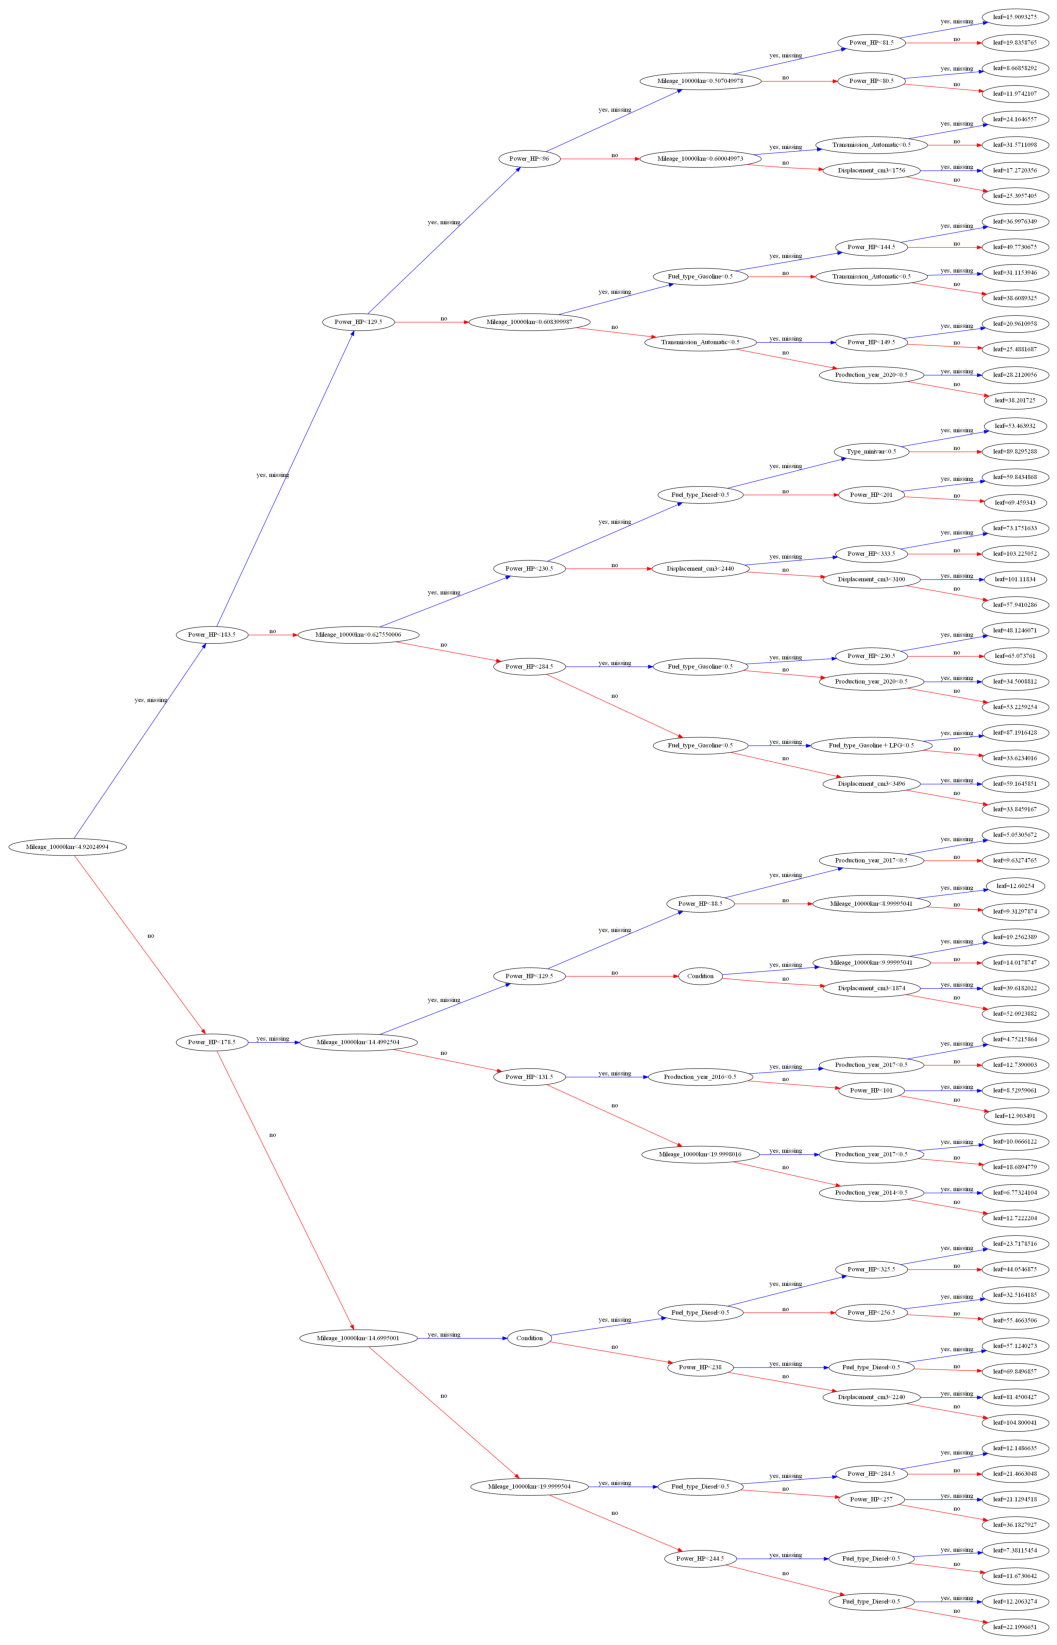

In [101]:
# plot single tree
plot_tree(model, num_trees=0, rankdir='LR')
plt.gcf().set_size_inches(40, 30)
plt.show()

Errors

In [102]:
SE = np.square(error) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
MAPE = mean_absolute_percentage_error(y_test, y_pred)

print('MSE: ', MSE,  '\nRMSE: ', RMSE, '\nMAPE: ', MAPE)


MSE:  277.42980404572836 
RMSE:  16.656224183341443 
MAPE:  0.244271469480597


### Feature Importance

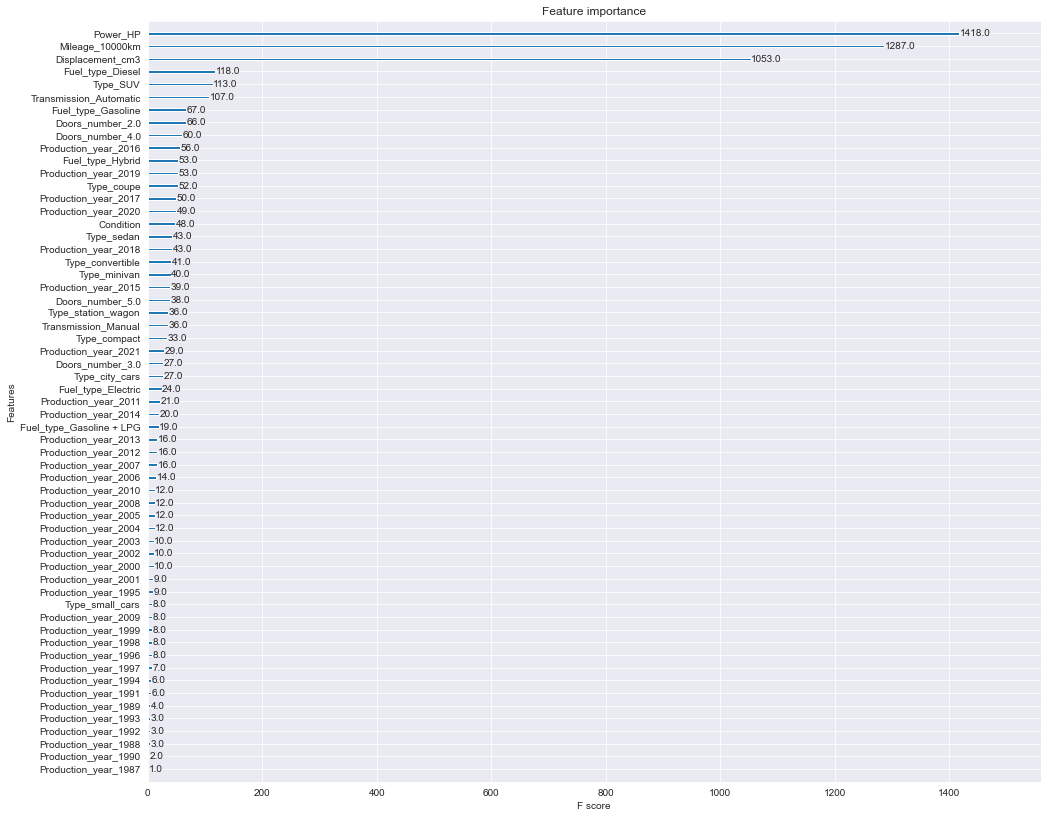

In [103]:
plt.rcParams["figure.figsize"] = (16, 14)
plot_importance(model)
plt.show()

### Feature selection

In [105]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train.values)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test.values)
	y_pred = selection_model.predict(select_X_test)

	error = y_pred - y_test
	SE = np.square(error) # squared errors
	MSE = np.mean(SE) # mean squared errors
	RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
	MAPE = mean_absolute_percentage_error(y_test, y_pred)
	if MAPE < 0.25:
		print("Thresh=%.3f, n=%d"% (thresh, select_X_train.shape[1]), ', MSE: ', MSE,  ', RMSE: ', RMSE, ', MAPE: ', MAPE)



Thresh=0.000, n=60 , MSE:  277.42980404572836 , RMSE:  16.656224183341443 , MAPE:  0.244271469480597
Thresh=0.000, n=59 , MSE:  277.42980404572836 , RMSE:  16.656224183341443 , MAPE:  0.244271469480597
Thresh=0.001, n=58 , MSE:  276.81272706847835 , RMSE:  16.63768995589467 , MAPE:  0.24393186188343663
Thresh=0.001, n=57 , MSE:  277.7054398274934 , RMSE:  16.6644963868547 , MAPE:  0.2438256929577766
Thresh=0.001, n=56 , MSE:  275.6336880564437 , RMSE:  16.60221937141067 , MAPE:  0.24426564247037652
Thresh=0.001, n=55 , MSE:  276.76408828838123 , RMSE:  16.636228186953353 , MAPE:  0.24389493846594068
Thresh=0.001, n=54 , MSE:  274.66865736376195 , RMSE:  16.57313058428497 , MAPE:  0.24546268196549173
Thresh=0.002, n=53 , MSE:  274.6032757270569 , RMSE:  16.571157947682984 , MAPE:  0.24694723418435807
Thresh=0.002, n=52 , MSE:  273.3759880911996 , RMSE:  16.534085644244122 , MAPE:  0.24628687877328928
Thresh=0.002, n=51 , MSE:  274.68051754037145 , RMSE:  16.573488393828605 , MAPE:  0.24

We can see that removing some of the features does not impact model MAPE.
Having less that 40 features increases MAPE.